In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import skimage.transform
from sklearn.model_selection import train_test_split
from network import neural_network
import cv2

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def read_pictures(directory='train/'):
    with open('files_list.txt') as f:
        files_list = f.readlines()
    files_list = [(directory+i.strip()) for i in files_list]
    return files_list

In [3]:
input_shape = (128, 128, 3)
# files_list = read_pictures('preprocessed_images/')
files_list = read_pictures()

In [4]:
def preprocess_img(img):
    return skimage.transform.resize(img, input_shape)

In [5]:
def get_dataset(preprocess = True, files_num=1000):
    X = np.empty((files_num, *input_shape), dtype=np.float32)
    y = np.empty((files_num, 2), dtype=np.uint8)
    
    files_to_read = np.random.choice(files_list, files_num)
    for num, i in enumerate(tqdm.tqdm(files_to_read)):
        if preprocess:
            X[num] = preprocess_img(cv2.imread(i))[:,:,::-1]
        else:
            X[num] = cv2.imread(i)[:,:,::-1]
            
        if 'cat' in i:
            y[num] = [1, 0]
        else:
            y[num] = [0, 1]
    return X, y

In [6]:
def save_preprocessed_images(images):
    for i, name in tqdm.tqdm(zip(images, files_list)):
        plt.imsave(f'preprocessed_images/{name.split("/")[-1]}', i)

In [7]:
X, y = get_dataset(preprocess=True, files_num=25000)
# X = X/np.max(X)

  0%|                                                                                        | 0/25000 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
100%|████████████████████████████████████████████████████████████████████████████| 25000/25000 [05:31<00:00, 75.36it/s]


In [8]:
# save_preprocessed_images(X)

25000it [01:51, 223.98it/s]


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

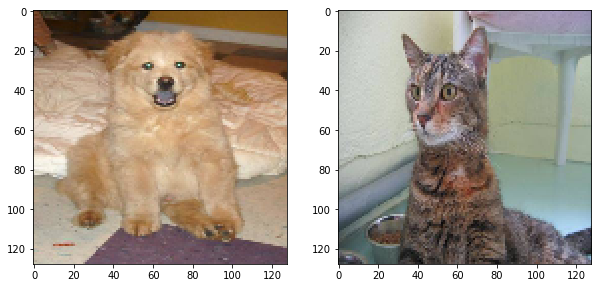

In [9]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(X[1]);
plt.subplot(122)
plt.imshow(X[0])
plt.show()

In [43]:
class cnn_network(neural_network):       
    def _inference(self):
        inp = self.input
        with tf.name_scope('classificator'):
            with tf.name_scope('convolution'):
#                 layer = tf.layers.conv2d(inp, 3, 1, activation=tf.nn.relu, name='deep_dreaming_input', padding='same')
                layer = tf.layers.conv2d(inp, 32, 3, activation=tf.nn.relu)
                layer = tf.layers.max_pooling2d(layer, pool_size=3, strides=2)
                layer = tf.layers.conv2d(layer, 32, 3, activation=tf.nn.relu)
                layer = tf.layers.max_pooling2d(layer, pool_size=3, strides=2)
                layer = tf.nn.dropout(layer, self.dropout_prob)
                layer = tf.layers.conv2d(layer, 32, 3, activation=tf.nn.relu)
                layer = tf.layers.max_pooling2d(layer, pool_size=3, strides=2)
#                 layer = tf.layers.conv2d(layer, 32, 3, activation=tf.nn.relu, padding='same')
#                 layer = tf.layers.max_pooling2d(layer, pool_size=3, strides=2)
                layer = tf.layers.conv2d(layer, 16, 5, activation=tf.nn.relu, padding='same')
                layer = tf.nn.dropout(layer, self.dropout_prob)
                layer = tf.layers.max_pooling2d(layer, pool_size=3, strides=2)
    #             layer = tf.layers.conv2d(layer, 16, 5, activation=tf.nn.relu)
    #             layer = tf.layers.max_pooling2d(layer, pool_size=3, strides=2)
                layer = tf.layers.flatten(layer)

            with tf.name_scope('dense'):
                layer = tf.layers.dense(layer, 1024, activation=tf.nn.relu)
                layer = tf.nn.dropout(layer, self.dropout_prob)
                layer = tf.layers.dense(layer, 512, activation=tf.nn.relu)
                layer = tf.layers.batch_normalization(layer)
                layer = tf.layers.dense(layer, 128, activation=tf.nn.relu)
                layer = tf.layers.batch_normalization(layer)
                layer = tf.layers.dense(layer, 2, activation=tf.nn.softmax)

        return layer

In [46]:
# if network is None:
tf.reset_default_graph()
network = cnn_network(input_shape, X_train, y_train, X_test, y_test)
network.training(batch_size=128, epochs=15, iter_before_validation=1)

  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Test accuracy: 65% 	Training loss: 0.6689473622862031 	 Training accuracy: 66%


  7%|█████▌                                                                             | 1/15 [00:05<01:22,  5.87s/it]

Test accuracy: 65% 	Training loss: 0.6023936468888731 	 Training accuracy: 67%


 13%|███████████                                                                        | 2/15 [00:11<01:14,  5.76s/it]

Test accuracy: 75% 	Training loss: 0.5647755966467016 	 Training accuracy: 69%


 20%|████████████████▌                                                                  | 3/15 [00:17<01:08,  5.72s/it]

Test accuracy: 77% 	Training loss: 0.5409034218858273 	 Training accuracy: 75%


 27%|██████████████████████▏                                                            | 4/15 [00:22<01:02,  5.70s/it]

Test accuracy: 76% 	Training loss: 0.5279847552232881 	 Training accuracy: 75%


 33%|███████████████████████████▋                                                       | 5/15 [00:28<00:56,  5.69s/it]

Test accuracy: 79% 	Training loss: 0.5163635256535867 	 Training accuracy: 79%


 40%|█████████████████████████████████▏                                                 | 6/15 [00:34<00:51,  5.68s/it]

Test accuracy: 81% 	Training loss: 0.5081775256377811 	 Training accuracy: 78%


 47%|██████████████████████████████████████▋                                            | 7/15 [00:39<00:45,  5.67s/it]

Test accuracy: 81% 	Training loss: 0.501834916498731 	 Training accuracy: 79%


 53%|████████████████████████████████████████████▎                                      | 8/15 [00:45<00:39,  5.67s/it]

Test accuracy: 79% 	Training loss: 0.49558117722763717 	 Training accuracy: 81%


 60%|█████████████████████████████████████████████████▊                                 | 9/15 [00:51<00:34,  5.67s/it]

Test accuracy: 82% 	Training loss: 0.4919919185340405 	 Training accuracy: 78%


 67%|██████████████████████████████████████████████████████▋                           | 10/15 [00:56<00:28,  5.67s/it]

Test accuracy: 83% 	Training loss: 0.48398424137164575 	 Training accuracy: 85%


 73%|████████████████████████████████████████████████████████████▏                     | 11/15 [01:02<00:22,  5.66s/it]

Test accuracy: 84% 	Training loss: 0.4739288593478061 	 Training accuracy: 84%


 80%|█████████████████████████████████████████████████████████████████▌                | 12/15 [01:07<00:16,  5.66s/it]

Test accuracy: 84% 	Training loss: 0.47116933631546337 	 Training accuracy: 87%


 87%|███████████████████████████████████████████████████████████████████████           | 13/15 [01:13<00:11,  5.66s/it]

Test accuracy: 84% 	Training loss: 0.4616673069403451 	 Training accuracy: 85%


 93%|████████████████████████████████████████████████████████████████████████████▌     | 14/15 [01:19<00:05,  5.67s/it]

Test accuracy: 85% 	Training loss: 0.4629709847709711 	 Training accuracy: 88%


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:25<00:00,  5.68s/it]


In [47]:
assert len([op.name for op in tf.get_default_graph().get_operations() if 'output' in op.name or 'features' in op.name]) == 2
assert len([op.name for op in tf.get_default_graph().get_operations() if 'cnn_' in op.name]) == 0

In [48]:
network.save_model('saved_model/classifier_small.ckpt')